In [176]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

#### Exercise 1

In [177]:
ret = pd.read_csv('../data/ford.csv', index_col=0, parse_dates=[0], usecols=[1, 2])
ret.head()

,FORD
X.m..d..y,
1984-02-02,0.025237
1984-02-03,-0.036923
1984-02-06,-0.015974
1984-02-07,-0.006494
1984-02-08,-0.013072


(a) Sample mean:

In [178]:
ret.FORD.mean()

0.0007600788763274999

Sample median:

In [179]:
ret.FORD.median()

0.0

Sample standard deviation:

In [180]:
ret.FORD.std()

0.018315568907245502

(b)

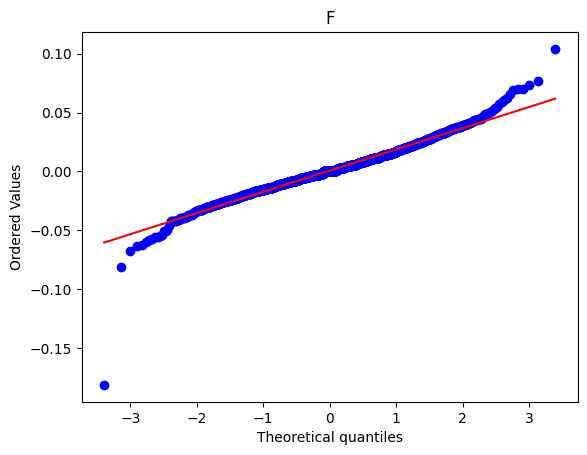

In [181]:
fig, ax = plt.subplots()
stats.probplot(ret.FORD, dist="norm", plot=ax)
ax.set_title('F');

The returns are non normally distributed, but rather exhibit fat tails.

(c)

The Shapiro-Wilk test rejects the null hypothesis of the normal distribution at 99% confidence level:

In [182]:
stats.shapiro(ret.FORD)

ShapiroResult(statistic=0.9638772010803223, pvalue=5.989972567072435e-22)

(d)

In [183]:
def plot_qq(ret, name, dfs):
    qs = np.array([0.25, 0.75])
    
    rows = math.ceil(len(dfs) / 2)
    fig, axs = plt.subplots(rows, 2, figsize=(12, 4 * rows))
    fig.suptitle(name)
    for i, df in enumerate(dfs):
        ax = axs[i // 2][i % 2]
        stats.probplot(ret, dist="t", sparams=df, plot=ax, fit=False)
        
        # draw a regression line through 0.25 and 0.75 quantiles
        coord = lambda q: (stats.t.ppf(q, df), np.quantile(ret, q))
        ax.axline(coord(qs[0]), coord(qs[1]), color='red')
        
        ax.set_title(f'df = {df}')
        ax.set_xlabel('')
    plt.show()

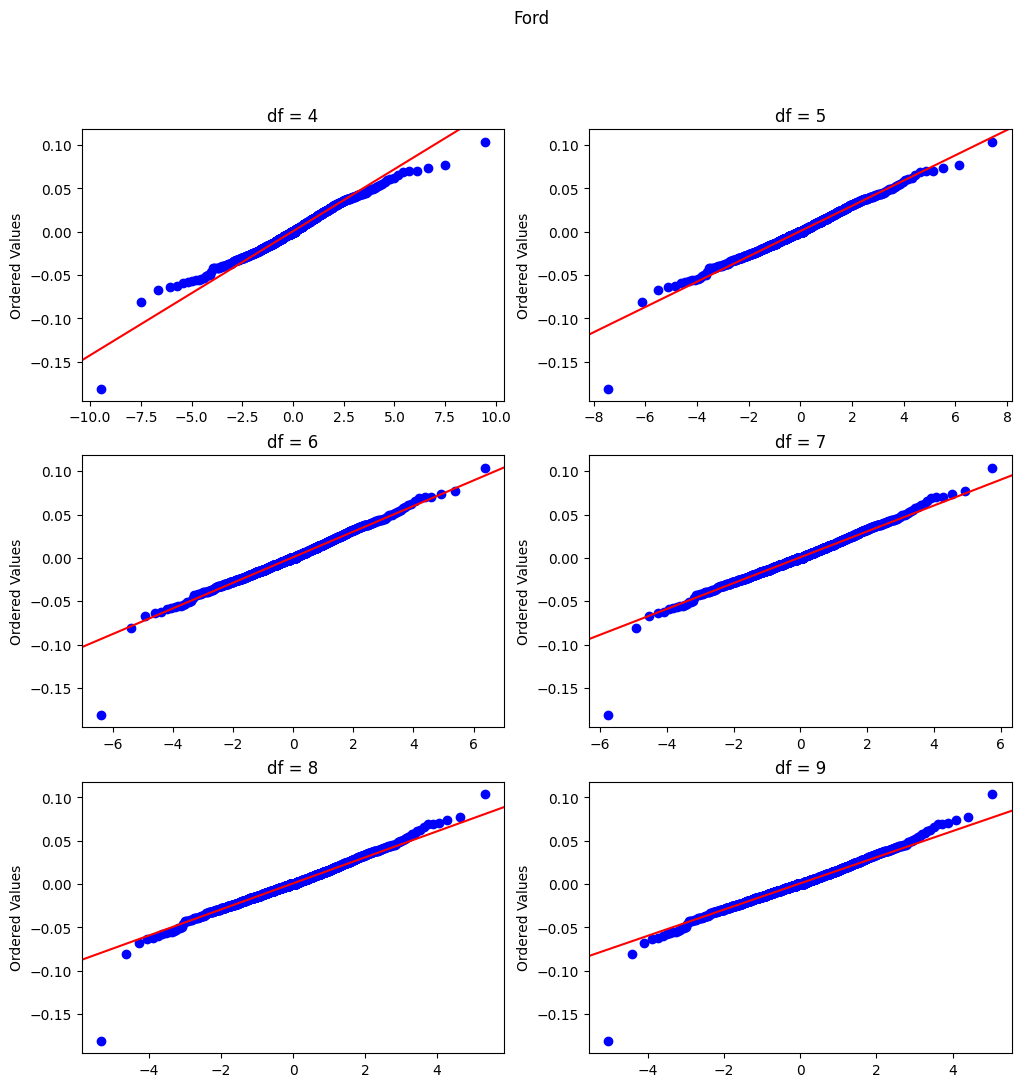

In [184]:
plot_qq(ret.FORD, 'Ford', [4, 5, 6, 7, 8, 9])

A t-distribution with 6 degress of freedom gives the best fit.

Generally, the return from Black Monday should not be ignored, as it represents an outcome realised in the market. One could, however, attempt to build separate models for the 'normal' and 'exceptions' regimes, where the model for the normal regime could ignore the exceptional return on October 19, 1987, and the model for the exceptional return take it into account.

(e)

In [185]:
from sklearn.neighbors import KernelDensity

In [186]:
# use the Silverman rule of thumb (https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/bandwidth)
def silverman_bw(vals):
    return 0.9 * min(np.std(vals, ddof=1), stats.iqr(vals) / 1.34) * len(vals) ** (-0.2)

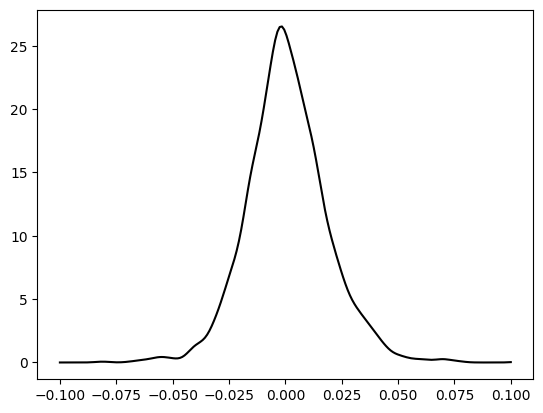

In [187]:
kde = KernelDensity(bandwidth=silverman_bw(ret.FORD), kernel='gaussian').fit(ret.FORD.values.reshape(-1, 1))

xs = np.linspace(-0.1, 0.1, 200)
vals = kde.score_samples(xs.reshape(-1, 1))

fig, ax = plt.subplots()
ax.plot(xs, np.exp(vals), color='black', label='KDE')

The standard error of the median using formula (4.3):

In [188]:
def q_std(a, q):
    n = len(a)
    Fm1 = np.quantile(a, q).reshape(-1, 1)
    return np.sqrt(q * (1 - q) / n) / (np.exp(kde.score_samples(Fm1)))[0]

In [189]:
q_std(ret.FORD, 0.5)

0.00042893578423884766

#### Exercise 2

In [190]:
prices = pd.read_csv('../data/RecentFord.csv', index_col=0, parse_dates=[0])
prices.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2009-01-02,2.30,2.49,2.28,2.46,42052300,2.32
2009-01-05,2.42,2.64,2.31,2.58,73031000,2.43
2009-01-06,2.64,2.85,2.63,2.76,58945900,2.60
2009-01-07,2.72,2.82,2.62,2.69,43931200,2.53
2009-01-08,2.62,2.70,2.50,2.69,51174500,2.53


In [191]:
ret = np.log(prices['Adj Close']).diff().dropna()

(a) Sample mean:

In [192]:
ret.mean()

0.0014948847501427707

Sample median:

In [193]:
ret.median()

0.0008146639961763569

Sample standard deviation:

In [194]:
ret.std()

0.026273058224053673

(b)

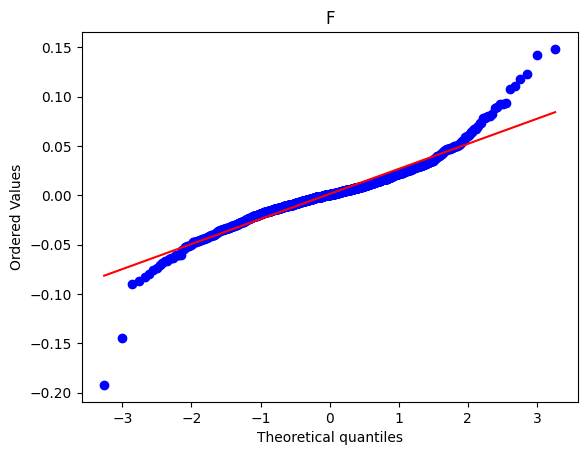

In [195]:
fig, ax = plt.subplots()
stats.probplot(ret, dist="norm", plot=ax)
ax.set_title('F');

The returns are clearly not normally distributed, but exhibit heavy tails with the right tail appearing heavier than the left one.

(c) The results of the Shapiro-Wilk reject the null hypothesis of normal distribution at 99% confidence:

In [196]:
stats.shapiro(ret)

ShapiroResult(statistic=0.9343971014022827, pvalue=4.4003686812404826e-23)

(d)

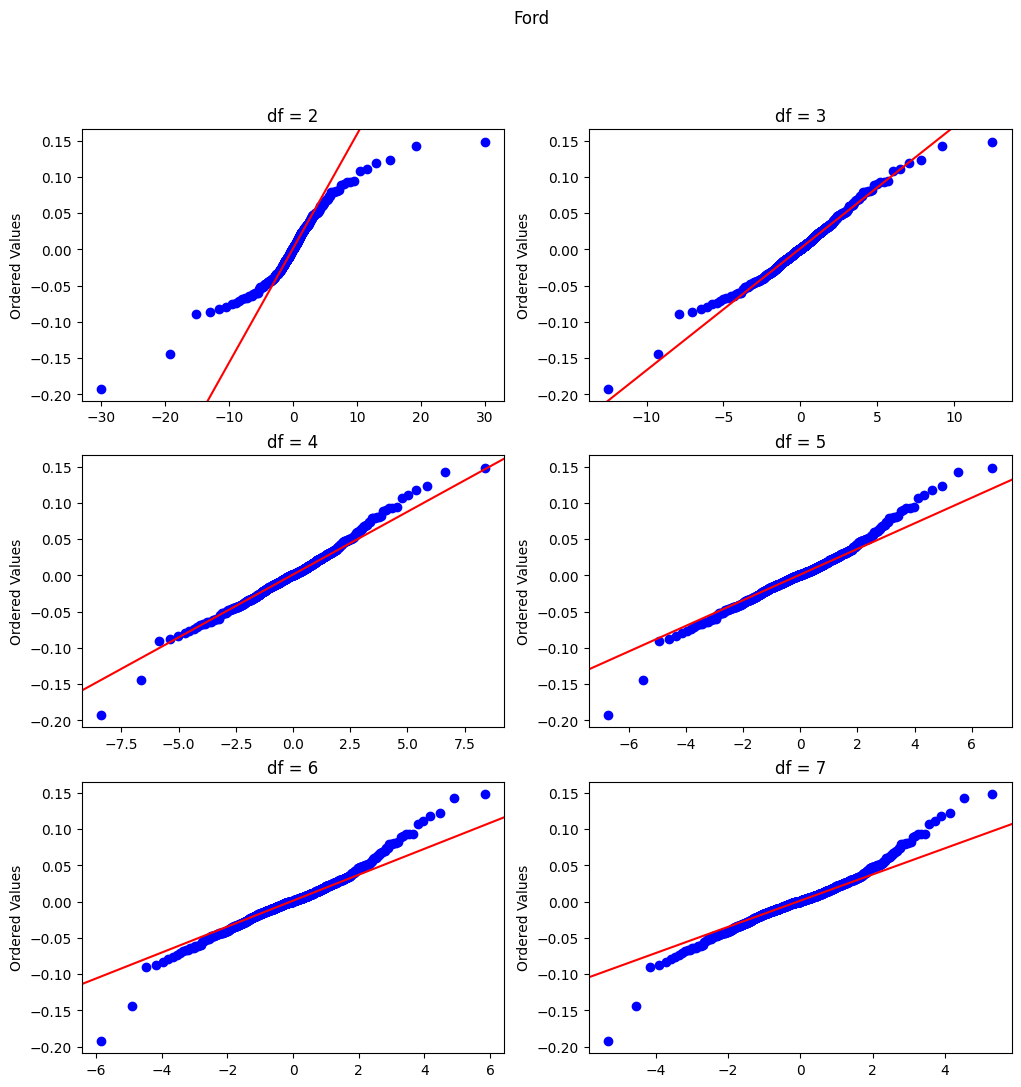

In [197]:
plot_qq(ret, 'Ford', [2, 3, 4, 5, 6, 7])

The t-distribution with 4 degrees of freedom offers the best fit.

(e)

In [198]:
q_std(ret, 0.5)

0.0005501409833143059

The lowest return occured on:

In [199]:
ret.index[ret.argmin()]

Timestamp('2009-05-12 00:00:00')

The log-return on that day was:

In [200]:
ret[ret.argmin()]

-0.19216000579424253

Ford announced a stock offering on May 12, 2009.

#### Exercise 3

In [201]:
data = pd.read_csv('../data/Garch.csv', usecols=[1, 2, 3, 4, 5, 6, 7, 8], index_col=0, parse_dates=[0])
data.head()

,day,dm,ddm,bp,cd,dy,sf
date,,,,,,,
1980-01-02,wednesday,0.5861,NaN,2.2490,0.8547,0.004206,0.6365
1980-01-03,thursday,0.5837,-0.004103,2.2365,0.8552,0.004187,0.6357
1980-01-04,friday,0.5842,0.000856,2.2410,0.8566,0.004269,0.6355
1980-01-07,monday,0.5853,0.001881,2.2645,0.8538,0.004315,0.6373
1980-01-08,tuesday,0.5824,-0.004967,2.2560,0.8553,0.004257,0.6329


In [202]:
values = data['dy'].diff().dropna()

(a)

In [203]:
values.mean()

1.5546623794212218e-06

In [204]:
values.std()

3.258823390388657e-05

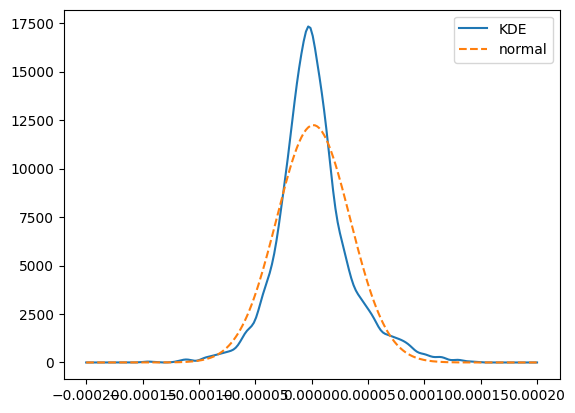

In [205]:
kde = KernelDensity(bandwidth=silverman_bw(values), kernel='gaussian').fit(values.values.reshape(-1, 1))

xs = np.linspace(-0.0002, 0.0002, 200)
vals = kde.score_samples(xs.reshape(-1, 1))

fig, ax = plt.subplots()
ax.plot(xs, np.exp(vals), label='KDE')
ax.plot(xs, stats.norm.pdf(xs, loc=values.mean(), scale=values.std()), '--', label='normal')
ax.legend();

The parametric estimate does not approximate the empirical density well, in particular the empirical density has heavier tails:

In [206]:
stats.kurtosis(values)

3.247228611833876

and is right-skewed:

In [207]:
stats.skew(values)

0.6493833604078297

(b)

In [208]:
values.median()

-1.0000000000001327e-06

In [209]:
stats.median_abs_deviation(values, scale='normal')

2.3721635496090208e-05

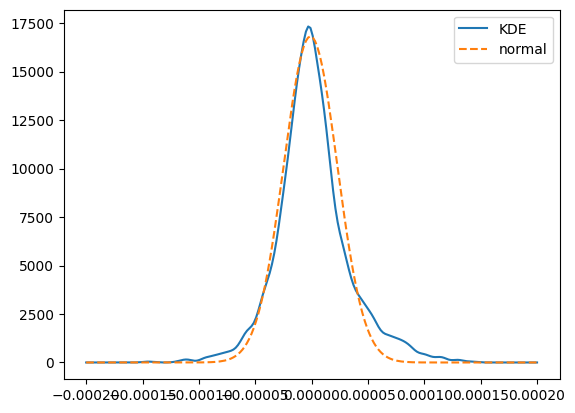

In [210]:
kde = KernelDensity(bandwidth=silverman_bw(values), kernel='gaussian').fit(values.values.reshape(-1, 1))

xs = np.linspace(-0.0002, 0.0002, 200)
vals = kde.score_samples(xs.reshape(-1, 1))

fig, ax = plt.subplots()
ax.plot(xs, np.exp(vals), label='KDE')
ax.plot(xs, stats.norm.pdf(xs, loc=values.median(), scale=stats.median_abs_deviation(values, scale='normal')), '--', label='normal')
ax.legend();

Using the median and MAD provides a much better fit for the region close to the median, however it still cannot replicate the kurtosis and skewness of the empirical distribution.

#### Exercise 4

(a) The empirical distribution is right-skewed.

(b) The empirical distribution is left-skewed.

(c) The empirical distribution has lighter tails than the theoretical distribution.

(d) The empirical distribution has heavier tails than the theoretical distribution.

#### Exercise 5

In [211]:
diffbp = data['bp'].diff().dropna()

(a)

In [212]:
def plot_qq_fit(ret):
    qs = np.array([0.25, 0.1, 0.05, 0.025, 0.01, 0.0025])

    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    for i, p in enumerate(qs):
        ax = axs[i // 2][i % 2]
        stats.probplot(ret, dist="norm", plot=ax, fit=False)

        # draw a regression line through q and (1-q) quantiles
        coord = lambda q: (stats.norm.ppf(q), np.quantile(ret, q))
        ax.axline(coord(p), coord(1 - p), color='red')

        ax.set_title(f'p = {p}')
        ax.set_xlabel('')
    plt.show()

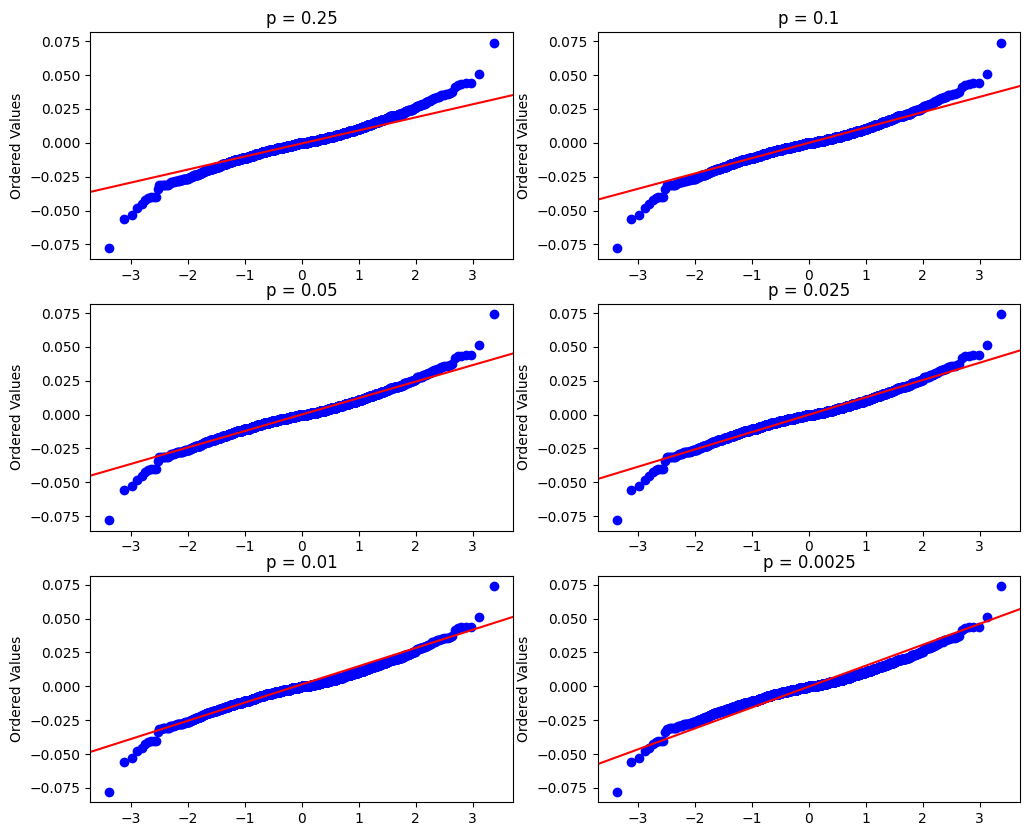

In [213]:
plot_qq_fit(diffbp)

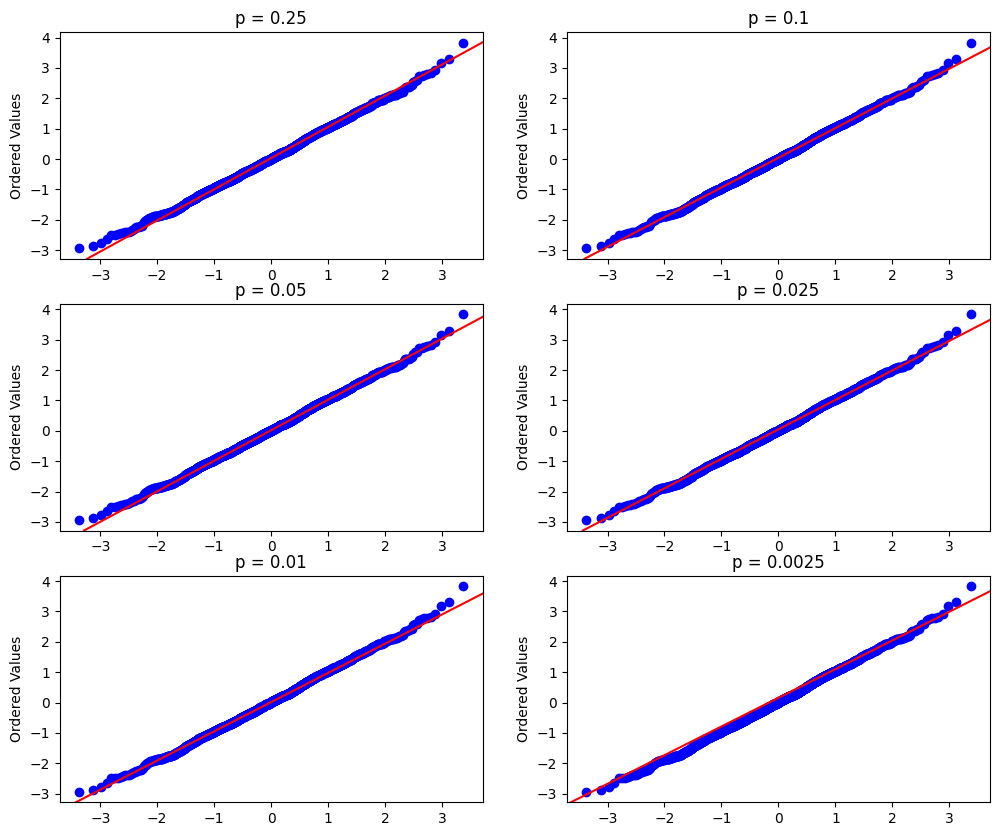

In [214]:
plot_qq_fit(stats.norm.rvs(size=len(diffbp)))

As $p$ increases, the reference line connects quantiles further away from the median. This has no effect on the plots for a sample from the normal distribution, but does change the shape of plots for a sample drawn from a different distribution, so could be used to indicate non-normality: the more the configuration of the plot changes with $p$, the further the empirical distribution is from the normal distribution.

(b)

In [215]:
log_diffbp = np.log(data['bp']).diff().dropna()

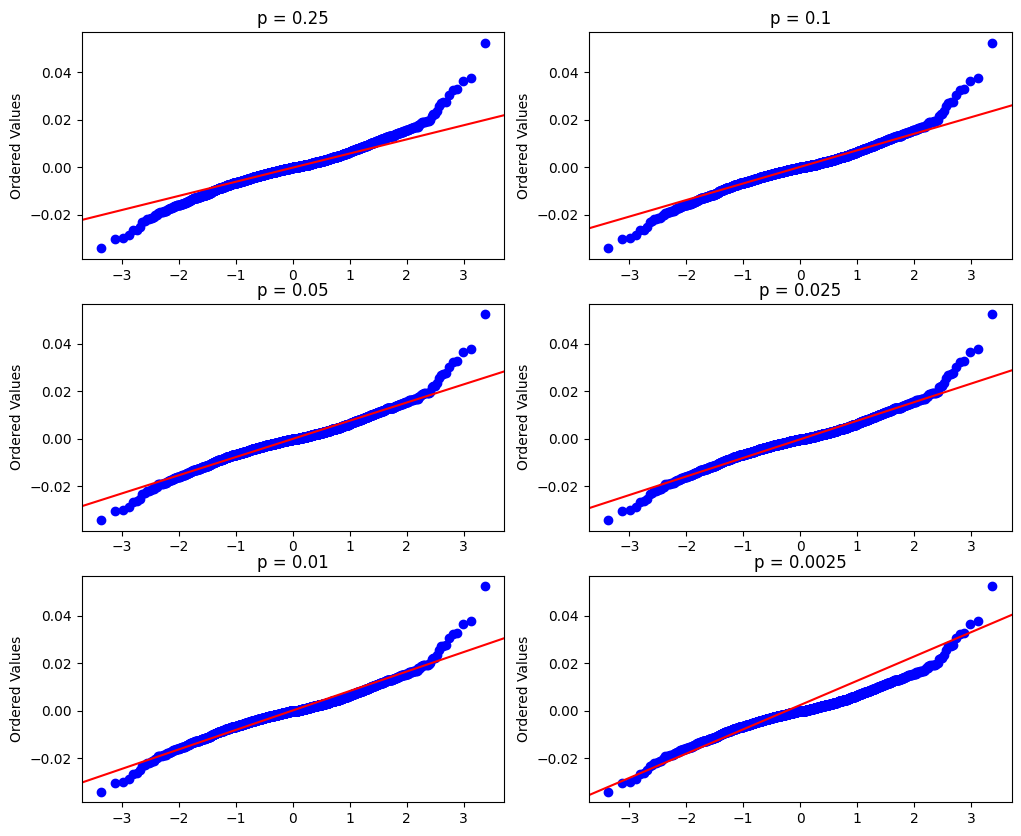

In [216]:
plot_qq_fit(log_diffbp)

The log differences look closer to being normally distributed, however they still exhibit significant right skew:

In [217]:
stats.skew(log_diffbp)

0.297650322371225

#### Exercise 6

(a) $\Phi^{-1}(0.975) = 1.96$ by the symmetry of the normal distribution.

(b) The 0.975-quantile of the normal distribution with mean -1 and variance 2 is $-1 + \sqrt{2} \Phi^{-1}(0.975)$:

In [218]:
-1 + np.sqrt(2) * stats.norm.ppf(0.975)

1.771807648699356

#### Exercise 7

Expression (4.3) is undefined for $q=0$ and $q=1$.

When $q=0$, $F^{-1}(q) \leq 0$, hence $f(F^{-1}(q)) = 0$.

Similarly, when $q=1$, $F^{-1}(q) \geq 1$, hence $f(F^{-1}(q)) = 0$.

For $0 < q < 1$, we have $F^{-1}(q) = q$ and $f(F^{-1}(q)) = 1$, so (4.3) becomes $\frac{q(1-q)}{n}$, which reaches its maximum at $q=1/2$ and is smallest when $q=0$ and $q=1$.

We conclude that the variance of quantile estimates is smallest for this distribution when $q \to 0$ or $q \to 1$.